![File Metadata](assets/FWlogo_small.png)

# Data curation with Flywheel Metadata: FLYQL and site statistics

Webinar Goals:
1. Use the Advanced Searth + SDK to Generate Collections of Curated Data Sets
    * Add Search Terms To Specify File Types
    * Create Collection and Add Data
    * Run this process iteratively
1. User Advanced Search to Visualze Site Statistics
    * Determine When Files Are Typically Created During The Day/Week
    * Determine If Files Are Created By Users vs Jobs
    * Determine Which Projects Are Generating The Most Files

# Let's get started! 

## ᕕ(ᐛ)ᕗ

# PART I: Data Curation With FLYQL

FLYQL ("Advanced Search") allows users to sort containers and files by any metadata
fields associated with that object.  
![File Metadata](assets/FileMetadata.png)


# Advanced Search Generation
- Brief UI review
- UI search to SDK search demo

## Return_type
What's the deal? ¯\\\_(ツ)\_/¯

In [4]:
query = 'file.classification.Measurement = T1'

results = fw.search({'structured_query': query, 'return_type': 'file'}, size=10000)
print(f'Files found: {len(results)}')

results = fw.search({'structured_query': query, 'return_type': 'acquisition'}, size=10000)
print(f'Acquisitions found: {len(results)}')

results = fw.search({'structured_query': query, 'return_type': 'session'}, size=10000)
print(f'Sessions found: {len(results)}')

results = fw.search({'structured_query': query, 'return_type': 'project'}, size=10000)
print(f'Projects found: {len(results)}')

Files found: 522
Acquisitions found: 334
Sessions found: 247
Projects found: 48


In [5]:
query = 'project.label = Sample'

results = fw.search({'structured_query': query, 'return_type': 'file'}, size=10000)
print(f'Files found: {len(results)}')

results = fw.search({'structured_query': query, 'return_type': 'acquisition'}, size=10000)
print(f'Acquisitions found: {len(results)}')

results = fw.search({'structured_query': query, 'return_type': 'session'}, size=10000)
print(f'Sessions found: {len(results)}')

results = fw.search({'structured_query': query, 'return_type': 'project'}, size=10000)
print(f'Projects found: {len(results)}')

Files found: 106
Acquisitions found: 50
Sessions found: 10
Projects found: 1


## Back to our slides  ( ﾟヮﾟ)☞

In [2]:
import flywheel
from pprint import pprint
import os
import matplotlib.pyplot as pl

fw = flywheel.Client(os.environ['API_KEY'])

In [6]:
age = 60
age_seconds = age * 365 * 24 * 60 * 60

query = f'session.age >= 0 AND session.age <= {age_seconds} AND ' \
        f'project.label = Sample AND ' \
        f'file.classification.Measurement = T1 AND ' \
        f'file.info.PatientIdentityRemoved = YES'

results = fw.search({'structured_query': query, 'return_type': 'acquisition'}, size=10000)

print(f'Number of results: {len(results)}')

Number of results: 6


# How to use these results in the SDK

Results are returned as python dictionaries
- always a good idea to look at one example result to see what the data structure is

In [7]:
pprint(results[0])

{'acquisition': {'created': datetime.datetime(2020, 7, 16, 15, 39, 7, 476000, tzinfo=tzutc()),
                 'id': '5f10749b957ea0063bc8a860',
                 'label': 'SAG T1_FIL',
                 'timestamp': None},
 'analysis': None,
 'collection': None,
 'file': None,
 'group': {'id': 'msk', 'label': 'MSK'},
 'parent': None,
 'permissions': [{'id': 'joshuajacobs@flywheel.io',
                  'role_ids': ['5ed5776610312c000faace60']},
                 {'id': 'davidparker@flywheel.io',
                  'role_ids': ['5ed5776610312c000faace60']}],
 'project': {'id': '5f107498957ea0063fc8a85b', 'label': 'Sample'},
 'return_type': 'acquisition',
 'session': {'created': datetime.datetime(2020, 7, 16, 15, 39, 6, 148000, tzinfo=tzutc()),
             'id': '5f10749a957ea0063bc8a85a',
             'label': '9999.85724100776049529661916682660945202985',
             'timestamp': None},
 'subject': {'code': '4557913065'}}


# Adding Results to a collection
Collections are curated datasets.  Any acquisition from and Group/Project can be added to a Collection.
Collections provide the following benefits:
- Batch run gears on subsets of data within/across projects
- Easily share only specific sets of data with collaborators
- Filter data based off any attached metadata

In [8]:
# Create a collection:
collection_id = fw.add_collection({'label': 'FLYQL Webinar'})
collection = fw.get_collection(collection_id)

In [9]:

# Loop through our results and add them to our collection:
for result in results:
    collection.add_acquisitions(result.acquisition.id)

# That was easy...***too*** easy... (≖_≖)
- Live demo of a more powerful application

In [ ]:
# Live Run Code for iteratively generating collections:

# A list of the items we wish to loop through 
decades = [20,30,40,50,60]
measurements = ['T2*, BOLD','T1']
intents = ['Functional','Structural']
# Calculate one decade in seconds
one_decade = 10 * 365 * 24 * 60 * 60

# Loop over the decades
for decade in decades:
    from_age = decade * 365 * 24 * 60 * 60
    to_age = from_age + one_decade - 1
    
    # Loop Over The Measurements
    for measurement, intent in zip(measurements, intents):

        query = f'session.age >= {from_age} AND session.age <= {to_age} AND '\
                f'file.classification.Measurement IN [{measurement}] AND '\
                f'file.classification.Intent = {intent} AND '\
                f'file.classification.Features != SBRef AND '\
                f'NOT acquisition.label CONTAINS .*SBRef.*'
        
        results = fw.search({'structured_query': query, 'return_type': 'acquisition', 'all_data':True}, size=10000)
        
        # If we got any results
        if len(results) > 0:
            print(f'Creating SiteWide_{intent}_decade_{decade}')
            # Create a collection for it
            collection_id = fw.add_collection({'label': f'SiteWide_{intent}_decade_{decade}'})
            collection = fw.get_collection(collection_id)
            
            # And populate
            for result in results:
                collection.add_acquisitions(result.acquisition.id)

# PART II: Advanced Search For Visualization

Advanced searches can be used for much more than just Collections.
- returned objects have useful metadata that can be ingested, processed, and visualized


# Visualize activity on the our flywheel instance/projects
a simple example

In [10]:
query = '(acquisition.modified >= 2020-08-12T04:00:00.000Z AND ' \
        'acquisition.modified <= 2020-08-13T04:00:00.000Z) OR' \
        '(session.modified >= 2020-08-12T04:00:00.000Z AND ' \
        'session.modified <= 2020-08-13T04:00:00.000Z) OR' \
        '(subject.modified >= 2020-08-12T04:00:00.000Z AND ' \
        'subject.modified <= 2020-08-13T04:00:00.000Z) OR' \
        '(file.modified >= 2020-08-12T04:00:00.000Z AND ' \
        'file.modified <= 2020-08-13T04:00:00.000Z) OR' \
        '(project.modified >= 2020-08-12T04:00:00.000Z AND ' \
        'project.modified <= 2020-08-13T04:00:00.000Z)'

results = fw.search({'structured_query': query, 'return_type': 'project'}, size=10000)

print(f'{len(results)} Projects have been modified in the past day')

4 Projects have been modified in the past day


# Query Complexity != Sophistication  
The info we got from that query is...not very impressive (︶︹︺)
- Complexity and sophistication comes from how you process the metadata returned with your search

### Example:
Using two much shorter searches, let's compare the number of files created by users vs jobs
over the past month (4 weeks):

In [3]:
# Find files made by users
query = 'file.origin.type = user AND '\
        'file.created <= 2020-08-17T04:00:00.000Z AND '\
        'file.created >= 2020-07-20T04:00:00.000Z'
user_files = fw.search({'structured_query': query, 'return_type': 'file'}, size=10000)

# Find files made by jobs
query = 'file.origin.type = job AND '\
        'file.created <= 2020-08-17T04:00:00.000Z AND '\
        'file.created >= 2020-07-20T04:00:00.000Z'
job_files = fw.search({'structured_query': query, 'return_type': 'file'}, size=10000)


In [4]:
print(f'{len(user_files)} User created files')
print(f'{len(job_files)} Job created files')

uvj_labels = f'Users: {len(user_files)}', f'Jobs: {len(job_files)}'
uvj_sizes = [int(len(user_files)), int(len(job_files))]

490 User created files
121 Job created files


In [ ]:
pl.pie(uvj_sizes, labels=uvj_labels, autopct='%1.1f%%',shadow=True, startangle=90)
pl.show()

![Piechart](assets/uvj_pie1.png)

# Dive Deeper

Let's attempt to get even more info from this metadata.

1. Break up our search so we search each week separately (for statistics!)
2. Perform more sophisticated metadata parsing

# Metadata Parsing
Let's make a helper function that will extract and manipulate metadata from the query results in a way that is useful to use.
- Use Pandas Dataframes for their useful data processing/plotting tools ( ﾟヮﾟ)

In [14]:
import pandas as pd

def dataframe_from_query(results):
    # Iterate through each item in the results, and build a DF with some key info
    # Assumes that the return_type is a file
    # Initialize a dictionary (It's just easier to build than a DF)
    data_dict = {'day_of_week':[],'hour':[], 'project':[], 'size':[],'date':[]}
    
    for result in results:
        # Extract the values of interest
        timestamp = result.file.get('created')
        dow = timestamp.strftime('%a')
        hour = timestamp.strftime('%H')
        project = result.project.get('label','NA')
        size = result.file.get('size',0)
        
        # Append each item to the dictonary
        data_dict['day_of_week'].append(dow)
        data_dict['project'].append(project)
        data_dict['size'].append(size)
        data_dict['date'].append(timestamp)
        data_dict['hour'].append(hour)
            
    # Create the Dataframe
    data_frame = pd.DataFrame.from_dict(data_dict)
    
    return(data_frame)

In [15]:
from datetime import datetime, timedelta
import numpy as np

In [16]:
# Determine the period to iterate over (7 days, 1 week)
one_week = timedelta(7)
to_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
from_time = to_time - one_week

In [17]:
# Initialize Dataframe
file_df = pd.DataFrame()

In [18]:
# Accumulate results over the past 4 time periods 
number_of_weeks = 4

for i in range(number_of_weeks):    
    # Create the query for this time period
    query = f'file.created > {from_time.isoformat()} AND ' \
            f'file.created <= {to_time.isoformat()}'
    
    # View the Query for debugging
    print(query)

    # Run the query
    results = fw.search({'structured_query': query, 'return_type': 'file'}, size=10000)
    
    # The query itself is a dictionary like object, 
    # but we'll create a dataframe of the info we're interested in
    new_file_df = dataframe_from_query(results)

    # Attaching the iteration period will help with statistics later
    new_file_df['week'] = i

    # Concatenate to the original dataframe
    file_df = pd.concat([file_df, new_file_df], axis=0)
    
    # Decrepent the start and stop times by the period 
    from_time = from_time - one_week
    to_time = to_time - one_week


file.created > 2020-08-11T00:00:00 AND file.created <= 2020-08-18T00:00:00
file.created > 2020-08-04T00:00:00 AND file.created <= 2020-08-11T00:00:00
file.created > 2020-07-28T00:00:00 AND file.created <= 2020-08-04T00:00:00
file.created > 2020-07-21T00:00:00 AND file.created <= 2020-07-28T00:00:00


### Magic Data Manipulation
## (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧
Covered in the code available online.  Just some basic pandas processing.

Text(0.5, 0, 'User vs Job File Creation')

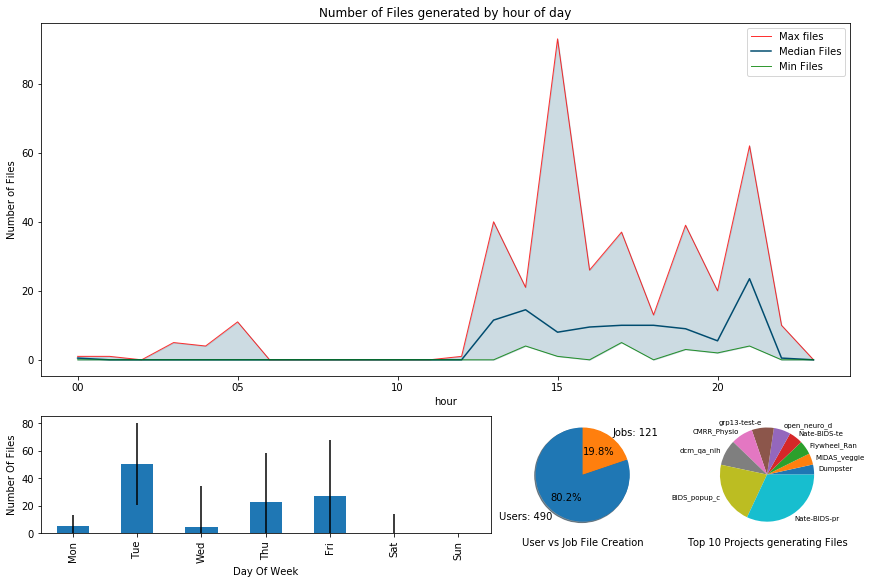

In [19]:
# Get Day Of Week Counts
dow_counts_fil =file_df.groupby(['week','day_of_week']).size().unstack(fill_value=0)  
# Get Hour Of Day Counts
hod_counts_fil =file_df.groupby(['week','hour']).size().unstack(fill_value=0)


day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
hour_order = [f'{val:02d}' for val in list(range(24))]

for d in day_order:
    if d not in dow_counts_fil.keys():
        dow_counts_fil[d] = 0
        
for h in hour_order:
    if h not in hod_counts_fil.keys():
        hod_counts_fil[h] = 0

# Gather stats for Day Of Week
# Rearrange the index so it's mon - sun
means_fil = dow_counts_fil.median().reindex(day_order)
std_fil = dow_counts_fil.std().reindex(day_order)

# Gather Stats for Hour of Day
maxs_fil = hod_counts_fil.max().reindex(hour_order)
mins_fil = hod_counts_fil.min().reindex(hour_order)
medians_fil = hod_counts_fil.median().reindex(hour_order)



# Fancy Plotting Time
# Create Figure and set up gridspec
fig = pl.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(4, 7)
ax_tod = fig.add_subplot(gs[0:3, :])
ax_dow = fig.add_subplot(gs[3:, 0:3])
ax_uvj = fig.add_subplot(gs[3:, 3:5])
ax_project = fig.add_subplot(gs[3:, 5:])


# Plot Day Of Week
means_fil.plot.bar(ax=ax_dow,yerr=std_fil)
ax_dow.set_ylabel('Number Of Files')
ax_dow.set_xlabel('Day Of Week')
ylim = ax_dow.get_ylim()
ax_dow.set_ylim([0, ylim[-1]])

# Plot Hour Of Day
maxs_fil.plot.line(ax=ax_tod, color='r', linewidth=1, alpha=0.8, label='Max files')
medians_fil.plot.line(ax=ax_tod, color='#004C6F', label='Median Files')
mins_fil.plot.line(ax=ax_tod, color='g', linewidth=1, alpha=0.8, label='Min Files')
ax_tod.fill_between(hour_order,maxs_fil.values,mins_fil.values, color='#004C6F', alpha=0.2)
ax_tod.set_ylabel('Number of Files')
ax_tod.set_title('Number of Files generated by hour of day')
ax_tod.legend()


projects_fil = file_df.groupby('project').size()  

# Project names can get very long.  Shorten them
short_labels = {}
for k in projects_fil.keys():
    short_labels[k] = k[0:12]
projects_fil = projects_fil.rename(short_labels)

projects_fil.sort_values()[-10:].plot.pie(title='',label='',ax=ax_project, textprops={'fontsize': 7}) 
ax_project.set_xlabel('Top 10 Projects generating Files')

# Add the users vs job 
ax_uvj.pie(uvj_sizes, labels=uvj_labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax_uvj.set_xlabel('User vs Job File Creation')


#pl.tight_layout()

![FileCreation](assets/FileCreation2.png)

# Final note on advanced search Vs finders
Many of the searches we made today can be replicated with [Finders](https://flywheel-io.gitlab.io/product/backend/sdk/branches/master/python/getting_started.html#working-with-finders).
#### Key Differences:
- Finders are slower, but always search the most recent data
- Finders have no "OR"
- Advanced searches are faster, but use Indexed data.  Indexing is not immediate when data is added
- Most objects have their own finders:
    - fw.jobs.find()
    - fw.projects.find()
    - fw.subjects.find()
    - fw.sessions.find()
    - fw.acquisitions.find()


#### Finders have multiple return types:
- **find()**: Returns ALL matching results at once (Slow for large numbers of matches)
- **find_first()**: Only returns the first result, no matter how many matches.  Very fast
- **iter_find()**: Returns an iterator that will stream all results to the SDK one by one as you need them.

In [4]:
# Compare Advanced search to fw.find

import time

query = f'acquisition.modified >= 2019-08-07 AND ' \
        f'acquisition.modified <= 2020-08-07'

tick = time.time()
adv_search = fw.search({'structured_query': query, 'return_type': 'acquisition', 'all_data':False}, size=10000)
tock = time.time()
adv_time = tock-tick

search = 'modified>=2019-08-07,modified<=2020-08-07'

tick = time.time()
finder = fw.acquisitions.find(search)
tock = time.time()
fnd_time = tock-tick


print(f'Advanced search took {adv_time} seconds')
print(f'Flywheel Finder took {fnd_time} seconds')

Advanced search took 0.6310322284698486 seconds
Flywheel Finder took 1.1835899353027344 seconds


# Thank you!   

## Questions?

![logo](assets/FWlogo_small.png)


# Bonus: Site Admin Tools

Site admins have access to two additional tools: the `jobs` finder, and the `access_logs` tool.



## Jobs Finder:
Allows for quick querying and indexing of all current and past jobs.  

## access_logs:
Allows for viewing of what user ID's have accessed flywheel, breaking "access" into the following categories:
- 'accept_failed_output',
- 'delete_container',
- 'view_container',
- 'view_subject',
- 'view_file',
- 'view_job',
- 'view_job_logs',
- 'download_file',
- 'replace_file',
- 'delete_file',
- 'delete_analysis',
- 'user_login',
- 'user_logout'

### Magic Data Manipulation
## (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧

Sudo Code:

_**define** helper function to parse metadata from the `jobs` finder_

_**define** helper function to parse metadata from the `access_logs` finder_

_loop over desired timeframes_

**for** 1 week at a time, going back 4 weeks:
   
   * _**run** query for jobs submitted that week_
   *  _**run** query for access logs that week_
   
   _**process** with functions_

_**curate** data with pandas_

_**plot**_


# Job Output
Let's run a query on the Jobs finder to look at all the jobs launched over the past 4 weeks.    
- from here, the output can also be analyzed and the metadata can be parsed to build an informative visualization


In [28]:

def dataframe_from_jobsearch(results):
    
    data_dict = {'day_of_week':[], 'hour':[], 'project':[], 'date':[],'gear':[]}
    
    for result in results:
        try:
            timestamp = result.get('created')
            dow = timestamp.strftime('%a')
            hour = timestamp.strftime('%H')
        except:
            timestamp=datetime(1,1,1,1)
        
        try:
            project_id = fw.get(result.destination.id).parents.project
            project = fw.get_project(project_id).label
        except:
            project_id = 'NA'
            project = 'NA'
            
        try:
            gear = result.gear_info.name    
        except:
            gear = 'NA'
            
        data_dict['day_of_week'].append(dow)
        data_dict['project'].append(project)
        data_dict['date'].append(timestamp)
        data_dict['gear'].append(gear)
        data_dict['hour'].append(hour)

        
    data_frame = pd.DataFrame.from_dict(data_dict)
    
    return(data_frame)

In [29]:
# NOTE this cell takes time.
# Initialize Dataframe
job_df = pd.DataFrame()

one_week = timedelta(7)
to_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
from_time = to_time - one_week


# Accumulate results over the past 4 weeks
number_of_weeks = 4

for i in range(number_of_weeks):
    print(i)
    
    search = f'created>{from_time.isoformat()},created<={to_time.isoformat()}'
    results = fw.jobs.iter_find(search)    
    new_job_df = dataframe_from_jobsearch(results)
    new_job_df['week'] = i
    
    job_df = pd.concat([job_df, new_job_df], axis=0)
    
    from_time = from_time - one_week
    to_time = to_time - one_week

0
1
2
3


Text(0.5, 0, 'Top 10 Gears Being Run')

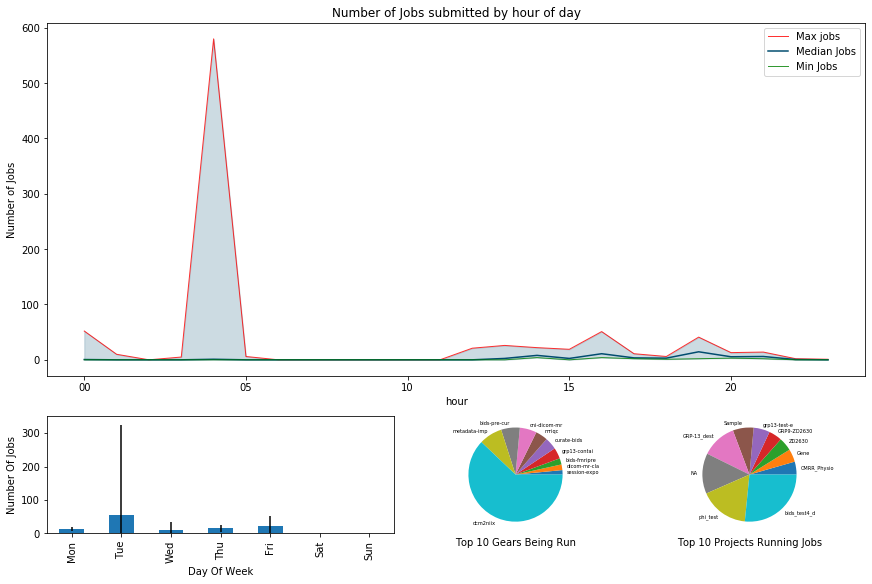

In [30]:
# Get Day Of Week Counts
dow_counts_job =job_df.groupby(['week','day_of_week']).size().unstack(fill_value=0)  
# Get Hour Of Day Counts
hod_counts_job =job_df.groupby(['week','hour']).size().unstack(fill_value=0)


day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
hour_order = [f'{val:02d}' for val in list(range(24))]

for d in day_order:
    if d not in dow_counts_job.keys():
        dow_counts_job[d] = 0
        
for h in hour_order:
    if h not in hod_counts_job.keys():
        hod_counts_job[h] = 0

# Gather stats for Day Of Week
# Rearrange the index so it's mon - sun
means_job = dow_counts_job.median().reindex(day_order)
std_job = dow_counts_job.std().reindex(day_order)

# Gather Stats for Hour of Day
maxs_job = hod_counts_job.max().reindex(hour_order)
mins_job = hod_counts_job.min().reindex(hour_order)
medians_job = hod_counts_job.median().reindex(hour_order)



# Fancy Plotting Time
# Create Figure and set up gridspec
fig = pl.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(4, 7)
ax_tod = fig.add_subplot(gs[0:3, :])
ax_dow = fig.add_subplot(gs[3:, 0:3])
ax_gear = fig.add_subplot(gs[3:, 3:5])
ax_project = fig.add_subplot(gs[3:, 5:])


# Plot Day Of Week
means_job.plot.bar(ax=ax_dow,yerr=std_job)
ax_dow.set_ylabel('Number Of Jobs')
ax_dow.set_xlabel('Day Of Week')
ylim = ax_dow.get_ylim()
ax_dow.set_ylim([0, ylim[-1]])

# Plot Hour Of Day
maxs_job.plot.line(ax=ax_tod, color='r', linewidth=1, alpha=0.8, label='Max jobs')
medians_job.plot.line(ax=ax_tod, color='#004C6F', label='Median Jobs')
mins_job.plot.line(ax=ax_tod, color='g', linewidth=1, alpha=0.8, label='Min Jobs')
ax_tod.fill_between(hour_order,maxs_job.values,mins_job.values, color='#004C6F', alpha=0.2)
ax_tod.set_ylabel('Number of Jobs')
ax_tod.set_title('Number of Jobs submitted by hour of day')
ax_tod.legend()


projects_job = job_df.groupby('project').size()  

# Project names can get very long.  Shorten them
short_labels = {}
for k in projects_job.keys():
    short_labels[k] = k[0:12]
projects_job = projects_job.rename(short_labels)

projects_job.sort_values()[-10:].plot.pie(title='',label='',ax=ax_project, textprops={'fontsize': 5}) 
ax_project.set_xlabel('Top 10 Projects Running Jobs')

# Now make the Gear graph
gears_job = job_df.groupby('gear').size()

short_labels = {}
for k in gears_job.keys():
    short_labels[k] = k[0:12]
gears_job = gears_job.rename(short_labels)

gears_job.sort_values()[-10:].plot.pie(title='',label='', ax=ax_gear, textprops={'fontsize': 5}) 
ax_gear.set_xlabel('Top 10 Gears Being Run')
#pl.tight_layout()

pl.show()

# Access Logs
Now let's look at the access logs for the past 4 weeks and build a similar dashboard,
 looking at logins and file downloads

In [34]:
def dataframe_from_accesslogs(results):
    
    data_dict = {'day_of_week':[], 'hour':[], 'project':[], 'date':[]}
    
    for result in results:
        if result.origin.type=='device':
            continue
        try:
            timestamp = result.get('timestamp')
            dow = timestamp.strftime('%a')
            hour = timestamp.strftime('%H')
        except:
            timestamp=datetime(1,1,1,1)
            dow = timestamp.strftime('%a')
            hour = timestamp.strftime('%H')
        
        try:
            project_id = result.context.project.label
        except:
            project_id = 'NA'
            
        data_dict['day_of_week'].append(dow)
        data_dict['project'].append(project_id)
        data_dict['date'].append(timestamp)
        data_dict['hour'].append(hour)

        
    data_frame = pd.DataFrame.from_dict(data_dict)
    
    return(data_frame)

In [35]:
# Initialize Dataframe
access_df = pd.DataFrame()

one_week = timedelta(7)
to_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
from_time = to_time - one_week


# Accumulate results over the past 4 weeks
number_of_weeks = 4

for i in range(number_of_weeks):
    print(i)
    access_logs = fw.get_access_log_report(start_date=from_time.isoformat(), end_date=to_time.isoformat(), access_type=['user_login'], limit=10000)
    new_access_df = dataframe_from_accesslogs(access_logs)
    new_access_df['week'] = i
    
    access_df = pd.concat([access_df, new_access_df], axis=0)
    
    from_time = from_time - one_week
    to_time = to_time - one_week
    




0
1
2
3


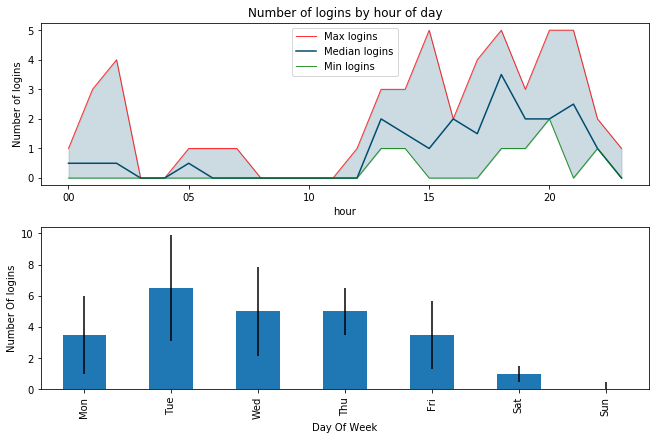

In [36]:
    

# Get Day Of Week Counts
dow_counts_lgn = access_df.groupby(['week','day_of_week']).size().unstack(fill_value=0)  
# Get Hour Of Day Counts
hod_counts_lgn = access_df.groupby(['week','hour']).size().unstack(fill_value=0)


day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
hour_order = [f'{val:02d}' for val in list(range(24))]

for d in day_order:
    if d not in dow_counts_lgn.keys():
        dow_counts_lgn[d] = 0
        
for h in hour_order:
    if h not in hod_counts_lgn.keys():
        hod_counts_lgn[h] = 0

# Rearrange the index so it's mon - sun
means_lgn = dow_counts_lgn.median().reindex(day_order)
std_lgn = dow_counts_lgn.std().reindex(day_order)

maxs_lgn = hod_counts_lgn.max().reindex(hour_order)
mins_lgn = hod_counts_lgn.min().reindex(hour_order)
medians_lgn = hod_counts_lgn.median().reindex(hour_order)

###########
# Fancy Plotting Time
# Create Figure and set up gridspec
fig = pl.figure(constrained_layout=True, figsize=(9,6))
gs = fig.add_gridspec(2, 1)
ax_tod = fig.add_subplot(gs[0, :])
ax_dow = fig.add_subplot(gs[1:, :])


# Plot Day Of Week
means_lgn.plot.bar(ax=ax_dow,yerr=std_lgn)
ax_dow.set_ylabel('Number Of logins')
ax_dow.set_xlabel('Day Of Week')
ylim = ax_dow.get_ylim()
ax_dow.set_ylim([0, ylim[-1]])


############

maxs_lgn.plot.line(ax=ax_tod, color='r', linewidth=1, alpha=0.8, label='Max logins')
medians_lgn.plot.line(ax=ax_tod, color='#004C6F', label='Median logins')
mins_lgn.plot.line(ax=ax_tod, color='g', linewidth=1, alpha=0.8, label='Min logins')
ax_tod.fill_between(hour_order,maxs_lgn.values,mins_lgn.values, color='#004C6F', alpha=0.2)
ax_tod.set_ylabel('Number of logins')
ax_tod.set_title('Number of logins by hour of day')
ax_tod.legend()
pl.show()


But we're still missing part of the puzzle here.  We have jobs and logins, but many people simply download the data from flywheel and process offline.  How can we capture that?  Well, another thing we can look at for the access logs is the file downloads:

In [37]:
# Initialize Dataframe
download_df = pd.DataFrame()

one_week = timedelta(7)
to_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
from_time = to_time - one_week


# Accumulate results over the past 4 weeks
number_of_weeks = 4

for i in range(number_of_weeks):
    print(i)
    access_logs = fw.get_access_log_report(start_date=from_time.isoformat(), end_date=to_time.isoformat(), access_type=['download_file'], limit=10000)
    new_download_df = dataframe_from_accesslogs(access_logs)
    new_download_df['week'] = i
    
    download_df = pd.concat([download_df, new_download_df], axis=0)
    
    from_time = from_time - one_week
    to_time = to_time - one_week
    
    



0
1
2
3


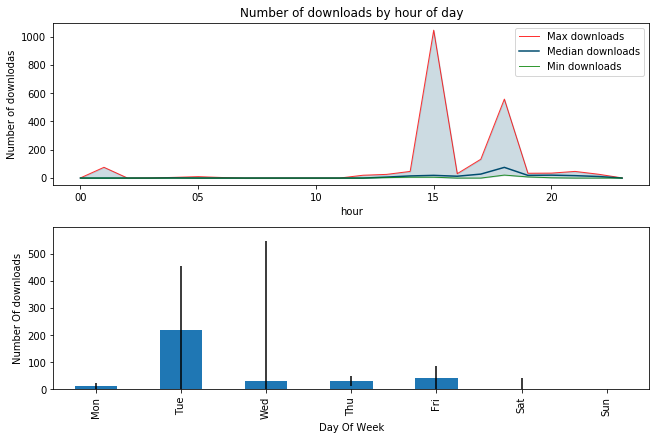

In [38]:
# Get Day Of Week Counts
dow_counts_dnl = download_df.groupby(['week','day_of_week']).size().unstack(fill_value=0)  
# Get Hour Of Day Counts
hod_counts_dln = download_df.groupby(['week','hour']).size().unstack(fill_value=0)


day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
hour_order = [f'{val:02d}' for val in list(range(24))]

for d in day_order:
    if d not in dow_counts_dnl.keys():
        dow_counts_dnl[d] = 0
        
for h in hour_order:
    if h not in hod_counts_dln.keys():
        hod_counts_dln[h] = 0


# Rearrange the index so it's mon - sun
# Get download counts for day of week
means_dwn = dow_counts_dnl.median().reindex(day_order)
std_dwn = dow_counts_dnl.std().reindex(day_order)

# Get download counts for time of day.
maxs_dwn = hod_counts_dln.max().reindex(hour_order)
mins_dwn = hod_counts_dln.min().reindex(hour_order)
medians_dwn = hod_counts_dln.median().reindex(hour_order)

###########
# Fancy Plotting Time
# Create Figure and set up gridspec
fig = pl.figure(constrained_layout=True, figsize=(9,6))
gs = fig.add_gridspec(2, 1)
ax_tod = fig.add_subplot(gs[0, :])
ax_dow = fig.add_subplot(gs[1:, :])


# Plot Day Of Week
means_dwn.plot.bar(ax=ax_dow,yerr=std_dwn)
ax_dow.set_ylabel('Number Of downloads')
ax_dow.set_xlabel('Day Of Week')
ylim = ax_dow.get_ylim()
ax_dow.set_ylim([0, ylim[-1]])


############

maxs_dwn.plot.line(ax=ax_tod, color='r', linewidth=1, alpha=0.8, label='Max downloads')
medians_dwn.plot.line(ax=ax_tod, color='#004C6F', label='Median downloads')
mins_dwn.plot.line(ax=ax_tod, color='g', linewidth=1, alpha=0.8, label='Min downloads')
ax_tod.fill_between(hour_order,maxs_dwn.values,mins_dwn.values, color='#004C6F', alpha=0.2)
ax_tod.set_ylabel('Number of downlodas')
ax_tod.set_title('Number of downloads by hour of day')
ax_tod.legend()
pl.show()

# Combine everything into one report
(This next cell is just plotting)

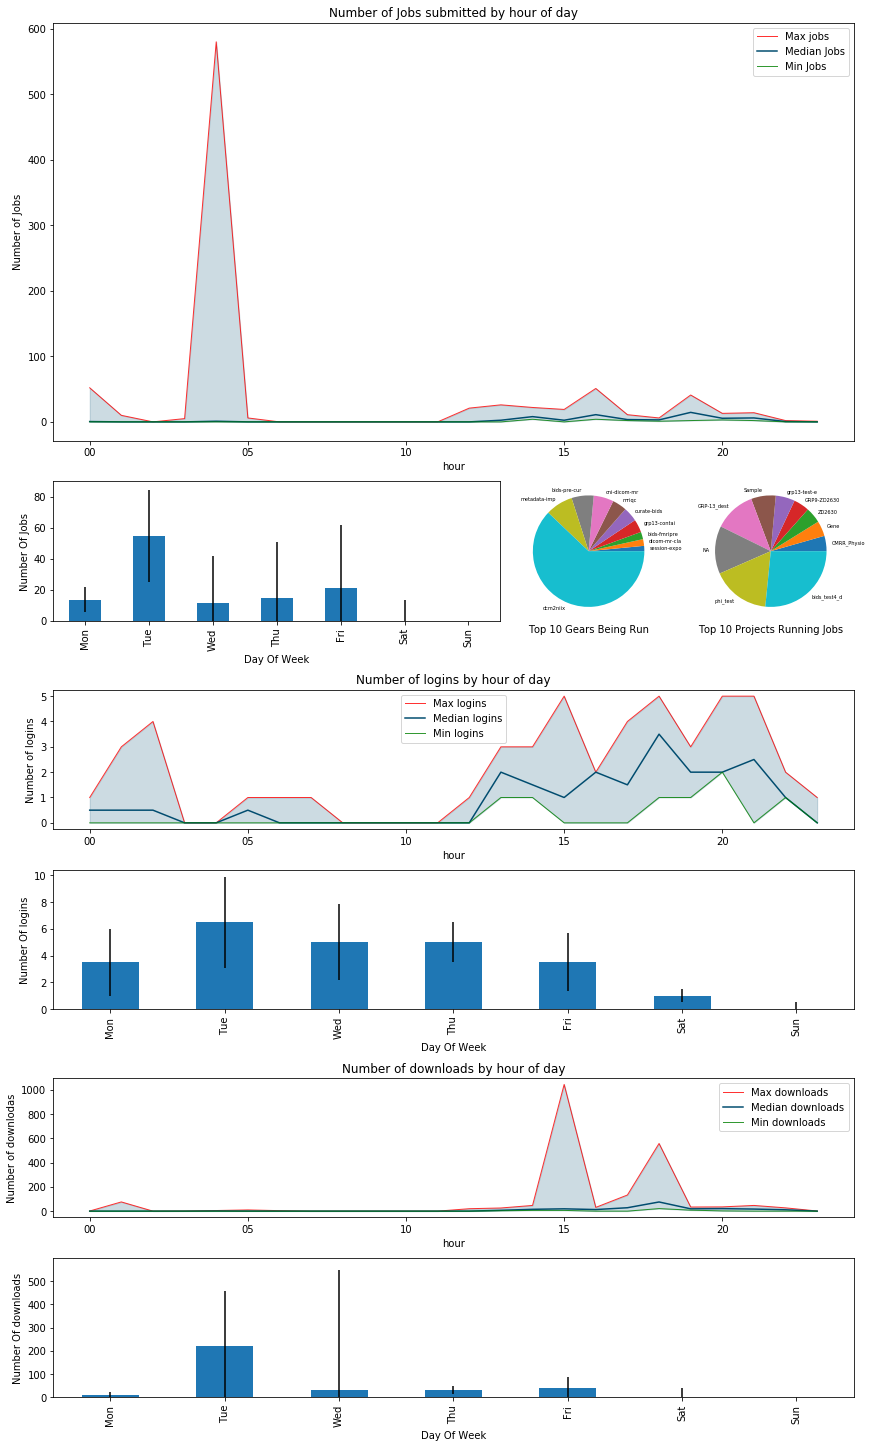

In [39]:

fig = pl.figure(constrained_layout=True, figsize=(12,20))
gs = fig.add_gridspec(8, 7)


############################################
# Jobs Submission

ax_job_tod = fig.add_subplot(gs[0:3, :])
ax_job_dow = fig.add_subplot(gs[3, 0:3])
ax_gear = fig.add_subplot(gs[3, 3:5])
ax_project = fig.add_subplot(gs[3, 5:])


# Plot Day Of Week
means_job.plot.bar(ax=ax_job_dow,yerr=std)
ax_job_dow.set_ylabel('Number Of Jobs')
ax_job_dow.set_xlabel('Day Of Week')
ylim = ax_job_dow.get_ylim()
ax_job_dow.set_ylim([0, ylim[-1]])

# Plot Hour Of Day
maxs_job.plot.line(ax=ax_job_tod, color='r', linewidth=1, alpha=0.8, label='Max jobs')
medians_job.plot.line(ax=ax_job_tod, color='#004C6F', label='Median Jobs')
mins_job.plot.line(ax=ax_job_tod, color='g', linewidth=1, alpha=0.8, label='Min Jobs')
ax_job_tod.fill_between(hour_order,maxs_job.values,mins_job.values, color='#004C6F', alpha=0.2)
ax_job_tod.set_ylabel('Number of Jobs')
ax_job_tod.set_title('Number of Jobs submitted by hour of day')
ax_job_tod.legend()



projects_job.sort_values()[-10:].plot.pie(title='',label='',ax=ax_project, textprops={'fontsize': 5}) 
ax_project.set_xlabel('Top 10 Projects Running Jobs')

# Now make the Gear graph
gears_job.sort_values()[-10:].plot.pie(title='',label='', ax=ax_gear, textprops={'fontsize': 5}) 
ax_gear.set_xlabel('Top 10 Gears Being Run')



###################################################################
# Logins
ax_tod = fig.add_subplot(gs[4, :])
ax_dow = fig.add_subplot(gs[5, :])


# Plot Day Of Week
means_lgn.plot.bar(ax=ax_dow,yerr=std_lgn)
ax_dow.set_ylabel('Number Of logins')
ax_dow.set_xlabel('Day Of Week')
ylim = ax_dow.get_ylim()
ax_dow.set_ylim([0, ylim[-1]])


############

maxs_lgn.plot.line(ax=ax_tod, color='r', linewidth=1, alpha=0.8, label='Max logins')
medians_lgn.plot.line(ax=ax_tod, color='#004C6F', label='Median logins')
mins_lgn.plot.line(ax=ax_tod, color='g', linewidth=1, alpha=0.8, label='Min logins')
ax_tod.fill_between(hour_order,maxs_lgn.values,mins_lgn.values, color='#004C6F', alpha=0.2)
ax_tod.set_ylabel('Number of logins')
ax_tod.set_title('Number of logins by hour of day')
ax_tod.legend()

###################################################################
# Downloads
ax_tod = fig.add_subplot(gs[6, :])
ax_dow = fig.add_subplot(gs[7, :])


# Plot Day Of Week
means_dwn.plot.bar(ax=ax_dow,yerr=std_dwn)
ax_dow.set_ylabel('Number Of downloads')
ax_dow.set_xlabel('Day Of Week')
ylim = ax_dow.get_ylim()
ax_dow.set_ylim([0, ylim[-1]])


############

maxs_dwn.plot.line(ax=ax_tod, color='r', linewidth=1, alpha=0.8, label='Max downloads')
medians_dwn.plot.line(ax=ax_tod, color='#004C6F', label='Median downloads')
mins_dwn.plot.line(ax=ax_tod, color='g', linewidth=1, alpha=0.8, label='Min downloads')
ax_tod.fill_between(hour_order,maxs_dwn.values,mins_dwn.values, color='#004C6F', alpha=0.2)
ax_tod.set_ylabel('Number of downlodas')
ax_tod.set_title('Number of downloads by hour of day')
ax_tod.legend()
pl.show()